# Functions of differential operators - nD

In this notebook we will learn how to

* compute functions (including exponential) of differential operators (`diffopexp`) one dimension at a time,
* create 1D symbols (`fouriersymbol`),
* create higher dimensional symbols (`tensorizesymbol`, `laplaciansymbol`),
* and apply them (`fourierproduct`, `fourierfn`, `laplacianop`, `laplacianopexp`) to compute functions of differential operators.

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag, float32, eye, kron
from torch.linalg import norm, matrix_exp

error = lambda u, uref : max(abs(u.flatten()-uref.flatten()))

## Functions of differential operators - higher dimensions, one dimension at a time

#### $\star$ `diffopexp`

For higher dimensions, `diffopexp` computes the exponential of an operator acting in a specific dimension `j`:

```Python
    eDjkf = ex.diffopexp(j, k, c, f, xrange) 
```
to compute $ e^{c \partial_{x_j}^k} f$. For instance, we compute $ e^{0.1 \partial_{y}^2} f$ and $ e^{3 \partial_{x}^3} f$ in the following code.

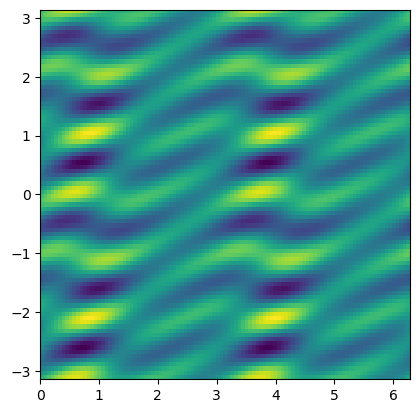

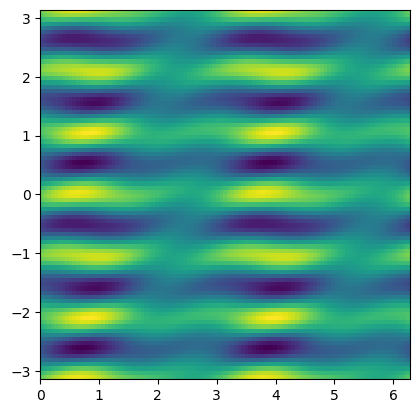

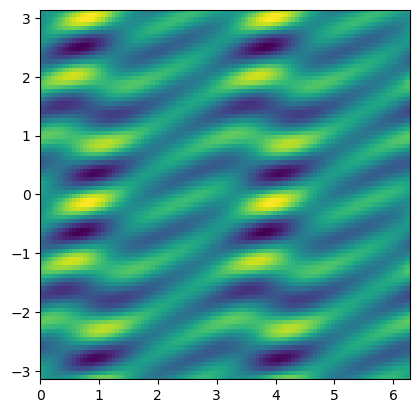

In [31]:
xrange = np.array([[0, 2*pi], [-pi, pi]])
n = [88, 103]
[x, y] = ex.grid(n, xrange)      # 2D grid

f = sin(8.*x+4.*y) + exp(sin(2.*y))*cos(6.*x)

eDy2f = ex.diffopexp(1, 2, 0.1, f, xrange) 
eDx3f = ex.diffopexp(0, 3, 3, f, xrange) 

plt.figure()
ex.imshow(plt, xrange, f)
plt.show()

plt.figure()
ex.imshow(plt, xrange, eDy2f)
plt.show()

plt.figure()
ex.imshow(plt, xrange, eDx3f)
plt.show()

#### $\star$ `fouriersymbol` and `fourierproduct`

As before, the same can be achieved by using `fouriersymbol` and `fourierproduct`. However, care has to be taken that `fouriersymbol` should only be created according to the specific dimension (i.e. direction) in which it needs to be applied: `n` should be the number of grid points in this direction and `xrange` should a list `[a,b]` which specifies the spatial extent in this direction. `fourierproduct` should then be applied as

```Python
    dgfs = ex.fourierproduct(g(c * sk), f, j)
```

As before, the equivalent of `diffopexp` is obtained by setting `g=exp`.

In [32]:
sx = ex.fouriersymbol(n[0], xrange[0])    
sy = ex.fouriersymbol(n[1], xrange[1])    

eDy2fs = real(ex.fourierproduct(exp(0.1*sy**2), f, 1)) 
eDx3fs = real(ex.fourierproduct(exp(3*sx**3), f, 0)) 

print(error(eDy2fs, eDy2f))
print(error(eDx3fs, eDx3f))

tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


We can see that the two methods are equivalent. As before, the `fouriersymbol` approach is more efficient since the symbol does not have to be computed multiple times. However, in higher dimensions this advantage is less pronounced when each differential operator is restricted to working in 1 dimension only. We will later see how to create higher dimensional symbols, where this advantage is restored.

Once again, unlike `diffopexp` which returns real-valued solutions where appropriate, we have to cast the output manually in the case of `fouriersymbol` and `fourierproduct` approach.

## Functions of differential operators - higher dimensions, all at once

The previous approach applies `fft` in the `j`th dimension only: i.e. the direction in which the differential operator $\partial_{x_j}^k$ acts. However, this may be inefficient. For instance, when we want to compute the action of the Laplacian, $\Delta$, or its functions (e.g. the exponential of Laplacian), it is more efficient to act on all directions at once - i.e. use `fftn` which transforms all direction, and use an n-dimensional symbol. 

#### $\star$ `tensorizesymbol`

We can create tensorized `x` and `y` symbols `Sx` and `Sy` using `tensorizesymbol` as

```Python
    [Sx, Sy] = ex.tensorizesymbol(symbolfn, n, xrange)
```

In general this can be done for arbitary dimensions. The `symbolfn` should be `ex.fouriersymbol` (unless you are using finite differences, or you know what you are doing). 

In [33]:
[Sx, Sy] = ex.tensorizesymbol(ex.fouriersymbol, n, xrange)
print(Sx.shape)
print(sx.shape)

print(Sy.shape)
print(sy.shape)

torch.Size([1, 88, 103])
torch.Size([88])
torch.Size([1, 88, 103])
torch.Size([103])


Note that the shape of the symbol `Sx` is `1 x nx x ny` unlike the symbol `sx` which has the shape `nx`.

We can then apply any function `g` of the symbols `Sx` and `Sy` using `fourierproduct` as

```Python
    dgfs = ex.fourierproduct(g(Sx, Sy), f)
```

For example,

* `g(Sx, Sy) = Sx + Sy` implements $\partial_x f + \partial_y f$
* `g(Sx, Sy) = Sx * Sy` implements $\partial_x \partial_y f$
* `g(Sx, Sy) = exp(Sx + 10.*Sy + 0.1*Sx**2)` implements $e^{\partial_x + 10 \partial_y + 0.1 \partial_x^2} f$

We check this against alternative ways of computing the same operators:

In [34]:
dxpyfs = real(ex.fourierproduct(Sx + Sy, f))
dxpyf = ex.diffop(0, 1, f, xrange) + ex.diffop(1, 1, f, xrange)

dxyfs = real(ex.fourierproduct(Sx * Sy, f))
dxyf = ex.diffop(0, 1, ex.diffop(1, 1, f, xrange), xrange)

expdxpyfs = real(ex.fourierproduct(exp(Sx + 10.*Sy + 0.1*Sx**2), f))
expdxpyf = ex.diffopexp(0, 2, 0.1, ex.diffopexp(0, 1, 1., ex.diffopexp(1, 1, 10., f, xrange), xrange), xrange)

print(error(dxpyfs, dxpyf))
print(error(dxyfs, dxyf))
print(error(expdxpyfs, expdxpyf))

tensor(7.6383e-14, dtype=torch.float64)
tensor(5.4421e-13, dtype=torch.float64)
tensor(4.4409e-16, dtype=torch.float64)


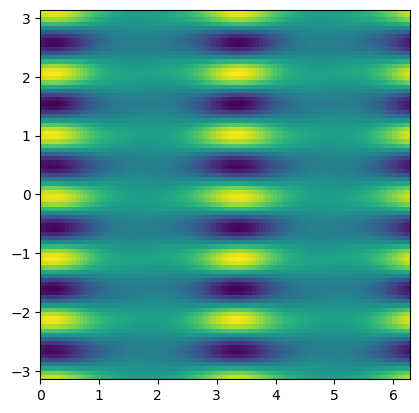

In [35]:
ex.imshow(plt, xrange, expdxpyfs)

#### $\star$ `fourierfn`

The same can be achieved with `fourierfn`

In [36]:
dxpyfs2 = ex.fourierfn(lambda S: S[0] + S[1], f, d=-1, xrange=xrange)
print(error(dxpyfs2, dxpyfs))

tensor(6.0927e-14, dtype=torch.float64)


Note:

* Since `fourierfn` creates the symbol internally each time, it is less efficient to use in general.
* You must pass `d=-1`, which is the way of specifying that the function acts on *all dimensions*. 
* Correspondingly, the function sent as the first parameter to `fourierfn` should take 2 inputs in 2D. 

#### $\star$ `laplaciansymbol`, `laplacianop` and  `laplacianopexp`

Due to the frequency with which the functions of Laplacian appear in practice, we have special functions just for the computation of its symbol and its functions.

The syntax for creating the symbol of the Laplacian follows that for `tensorizesymbol`:

```Python
    SL = ex.laplaciansymbol(symbolfn, n, xrange)
```

As before, the `symbolfn` should be `ex.fouriersymbol` (unless you are using finite differences, or you know what you are doing). 

A difference now is that `SL` is no longer a list of `x` and `y` symbols, `Sx` and `Sy`. Instead it is the special function of these `SL = Sx**2 + Sy**2` (in higher dimensions, this generalizes to be a sum of the square of all individual direction symbols). This makes it possible to combine it with `fourierproduct` function immediately to compute the action of the Laplacian and its functions.

In the following example we show how to compute $\Delta f$ and $e^{0.1 \Delta} f$ using `laplaciansymbol`. The result is the same as using `diffop` and `diffopexp` appropriately.

In [37]:
SL = ex.laplaciansymbol(ex.fouriersymbol, n, xrange)

print(error(SL, Sx**2 + Sy**2))

Lf = real(ex.fourierproduct(SL, f))
expLf = real(ex.fourierproduct(exp(0.1 * SL), f))

Lf2 = ex.diffop(0, 2, f, xrange) + ex.diffop(1, 2, f, xrange)
expLf2 = ex.diffopexp(0, 2, 0.1, ex.diffopexp(1, 2, 0.1, f, xrange) , xrange) 

print(error(Lf, Lf2))
print(error(expLf, expLf2))

tensor(0., dtype=torch.float64)
tensor(2.1032e-12, dtype=torch.float64)
tensor(2.4286e-16, dtype=torch.float64)


The `laplacianop` function provides a light wrapper around the above functionality. It is called as:

```Python
    Lf = ex.laplacianop(lapsymb, f)
```
and computes the action of the Laplacian on `f`. The only difference from `fourierproduct` is that `laplacianop` takes care of real and complex-valued inputs correctly.

`laplacianopexp` provides a similarly light wrapper for computation of Laplacian exponential. It is called as

```Python
    expLf = ex.laplacianopexp(lapsymb, s, u):
```
for the computation of $e^{s \Delta} f$ for a scalar $s$.


In [38]:
Lf3 = ex.laplacianop(SL, f)
expLf3 = ex.laplacianopexp(SL, 0.1, f)

print(error(Lf, Lf2))
print(error(expLf, expLf2))

tensor(2.1032e-12, dtype=torch.float64)
tensor(2.4286e-16, dtype=torch.float64)
